In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [2]:
# Load the dataset and skip meta-information columns.
df = pd.read_excel(r'/content/AandE-Admissions_Dataset.xlsx', skiprows= 3)

# Change the missing column names.
df = df.rename(columns={'Unnamed: 0': 'Weekday', 'Unnamed: 1': "Hour of arrival"})
print('This is the basic dataset information:')

# See amount of observations and types.
print('\n')
df.info()

# "Self-harm" and "Sports Injury" columns are not read as integers because of invalid values.
print('\n')
print('This is the initial dataset:')
display(df.head())

This is the basic dataset information:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Weekday                 168 non-null    object
 1   Hour of arrival         168 non-null    object
 2   Road traffic accident   168 non-null    int64 
 3   Assault                 168 non-null    int64 
 4   Deliberate self-harm    168 non-null    object
 5   Sports injury           168 non-null    object
 6   Not known               168 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 9.3+ KB


This is the initial dataset:


,Weekday,Hour of arrival,Road traffic accident,Assault,Deliberate self-harm,Sports injury,Not known
0,Monday,00:00:00,101,127,44,36,230
1,Monday,01:00:00,59,92,46,8,185
2,Monday,02:00:00,37,84,*,*,150
3,Monday,03:00:00,32,45,27,11,118
4,Monday,04:00:00,24,56,16,14,93


In [3]:
# Remove duplicate rows.
df = df.drop_duplicates()

# Replace invalid entries with NaN for program interpretation.
df['Deliberate self-harm '] = df[
    'Deliberate self-harm '].apply(lambda x: float('nan') if x == '*' else int(x))
df['Sports injury '] = df[
    'Sports injury '].apply(lambda x: float('nan') if x == '*' else int(x))

# Fill these with the mean between the hour before and after that observation.
columns_to_fix = ['Deliberate self-harm ', 'Sports injury ']
for column in columns_to_fix:
    df[column] = df[column].interpolate(method='linear', limit_direction='both')

In [4]:
# Check for negative values in numeric columns.
numeric_columns = df.select_dtypes(include=['number']).columns
if (df[numeric_columns]<0).any().any():
    print('There are negative values in the Dataset.')
else:
    print('\n Data cleaning completed.')


 Data cleaning completed.


In [5]:
# Converting "Hour" column to a numerical format to assign three 8 hour shifts.
df['Hour of arrival'] = (
    df['Hour of arrival'].astype(str).str.replace(':', '').astype(int))/10000

# Defining a function to assign shift categories.
def shift(hour):
    if 0 <= hour < 8:
        return 'Night shift'
    elif 8 <= hour < 16:
        return 'Morning shift'
    else:
        return 'Evening shift'

In [6]:
# Create and add new columns with each hour's shift and total admissions.
df['Shift'] = df['Hour of arrival'].apply(shift)
df['Total'] = df['Road traffic accident '] + df[
    'Sports injury '] + df['Deliberate self-harm '] + df['Assault '] + df['Not known ']
print('\n')
print('Shift and Total columns have been added.')

# Define and apply the order of weekdays and shifts.
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shift_order = ['Night shift', 'Morning shift', 'Evening shift']
df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)
df['Shift'] = pd.Categorical(df['Shift'], categories=shift_order, ordered=True)



Shift and Total columns have been added.


In [7]:
# Display the cleaned and expanded dataset and its statistical summary.
print('\n')
print('This is the cleaned and extended dataset:')
display(df.head())
print('\n')

print('These are the summary statistics:')
print(tabulate(df.describe(), headers='keys', tablefmt='fancy_grid'))
print("\n")



This is the cleaned and extended dataset:


,Weekday,Hour of arrival,Road traffic accident,Assault,Deliberate self-harm,Sports injury,Not known,Shift,Total
0,Monday,0.0,101,127,44.0,36.0,230,Night shift,538.0
1,Monday,1.0,59,92,46.0,8.0,185,Night shift,390.0
2,Monday,2.0,37,84,36.5,9.5,150,Night shift,317.0
3,Monday,3.0,32,45,27.0,11.0,118,Night shift,233.0
4,Monday,4.0,24,56,16.0,14.0,93,Night shift,203.0




These are the summary statistics:
╒═══════╤═══════════════════╤══════════════════════════╤════════════╤═════════════════════════╤══════════════════╤══════════════╤══════════╕
│       │   Hour of arrival │   Road traffic accident  │   Assault  │   Deliberate self-harm  │   Sports injury  │   Not known  │    Total │
╞═══════╪═══════════════════╪══════════════════════════╪════════════╪═════════════════════════╪══════════════════╪══════════════╪══════════╡
│ count │         168       │                  168     │   168      │                168      │          168     │      168     │  168     │
├───────┼───────────────────┼──────────────────────────┼────────────┼─────────────────────────┼──────────────────┼──────────────┼──────────┤
│ mean  │          11.5     │                  181.101 │   104.292  │                 35.8214 │          183.417 │      212.113 │  716.744 │
├───────┼───────────────────┼──────────────────────────┼────────────┼─────────────────────────┼──────────────────┼────



INSIGHT 1: Total admissions for each 8 hour shift across the week.


<ipython-input-8-2e8247021624>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shift_totals = (df.groupby(['Weekday', 'Shift'])['Total'].sum().reset_index())


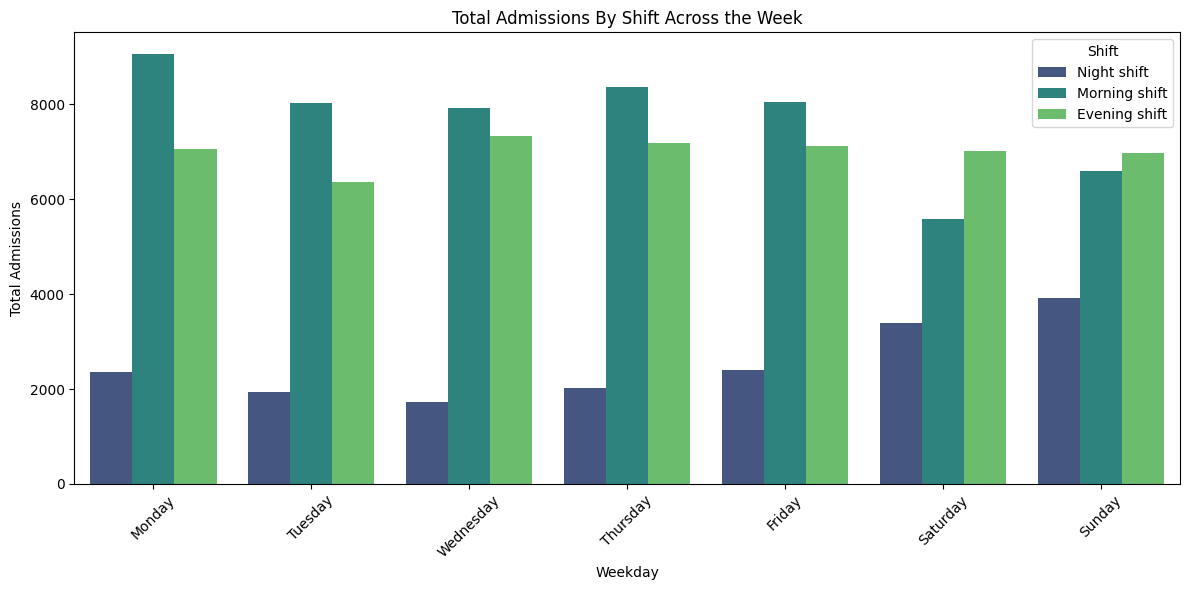

In [8]:
# Calculate the total admissions per each combination of 'Weekday' and 'Shift'.
shift_totals = (df.groupby(['Weekday', 'Shift'])['Total'].sum().reset_index())

# Bar plot of total admissions per shift and weekday.
print('\n')
print('INSIGHT 1: Total admissions for each 8 hour shift across the week.')

plt.figure(figsize=(12, 6))
sns.barplot(data=shift_totals,x='Weekday',y='Total',
            hue='Shift',palette='viridis',dodge=True,width=0.8)
plt.title('Total Admissions By Shift Across the Week')
plt.ylabel('Total Admissions')
plt.xlabel('Weekday')
plt.legend(title='Shift')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Observation: Clear change of admissions per shift behaviour between weekdays and weekends.

<ipython-input-9-57629fad419a>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby('Weekday')[['Road traffic accident ',



 INSIGHT 2: Admissions by Reason of Attendance and Day of the week.


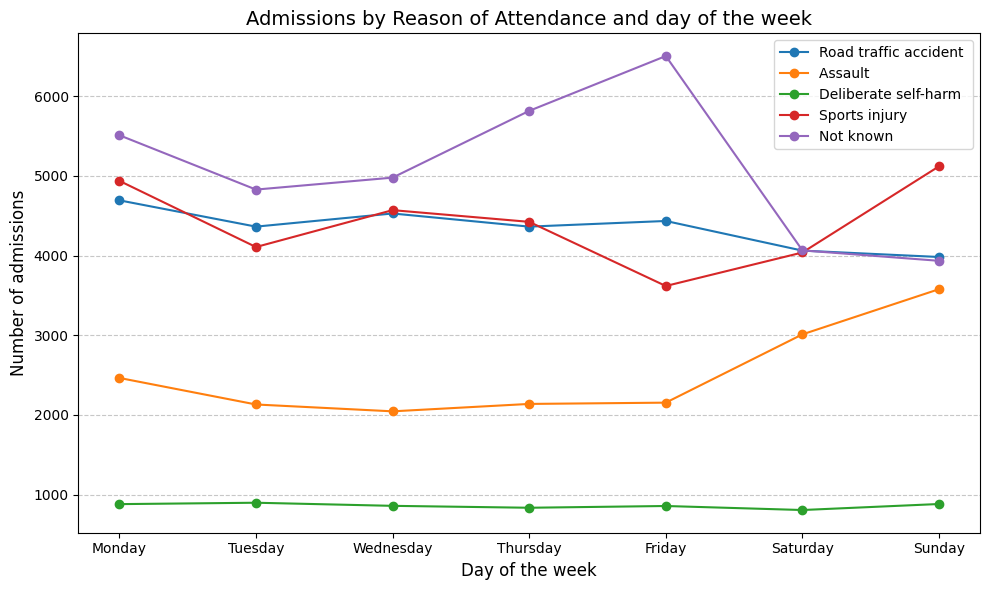

In [9]:
# Compute sum of admission types grouped by weekday.
grouped_data = df.groupby('Weekday')[['Road traffic accident ',
            'Assault ', 'Deliberate self-harm ', 'Sports injury ', 'Not known ']].sum()

# Line plot for trends in types of admissions across the week.
print('\n INSIGHT 2: Admissions by Reason of Attendance and Day of the week.' )

plt.figure(figsize=(10, 6))
adtype_columns = ['Road traffic accident ',
                  'Assault ', 'Deliberate self-harm ', 'Sports injury ', 'Not known ']
for column in adtype_columns:
    plt.plot(grouped_data.index, grouped_data[column], label=column, marker='o')

plt.title('Admissions by Reason of Attendance and day of the week', fontsize=14)
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Number of admissions', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# Observation: Unknown, Assault and Sports Injuries admissions vary significantly by day of the week.


 INSIGHT 3: Normalised average Admissions per Reason and Hour of the Arrival.


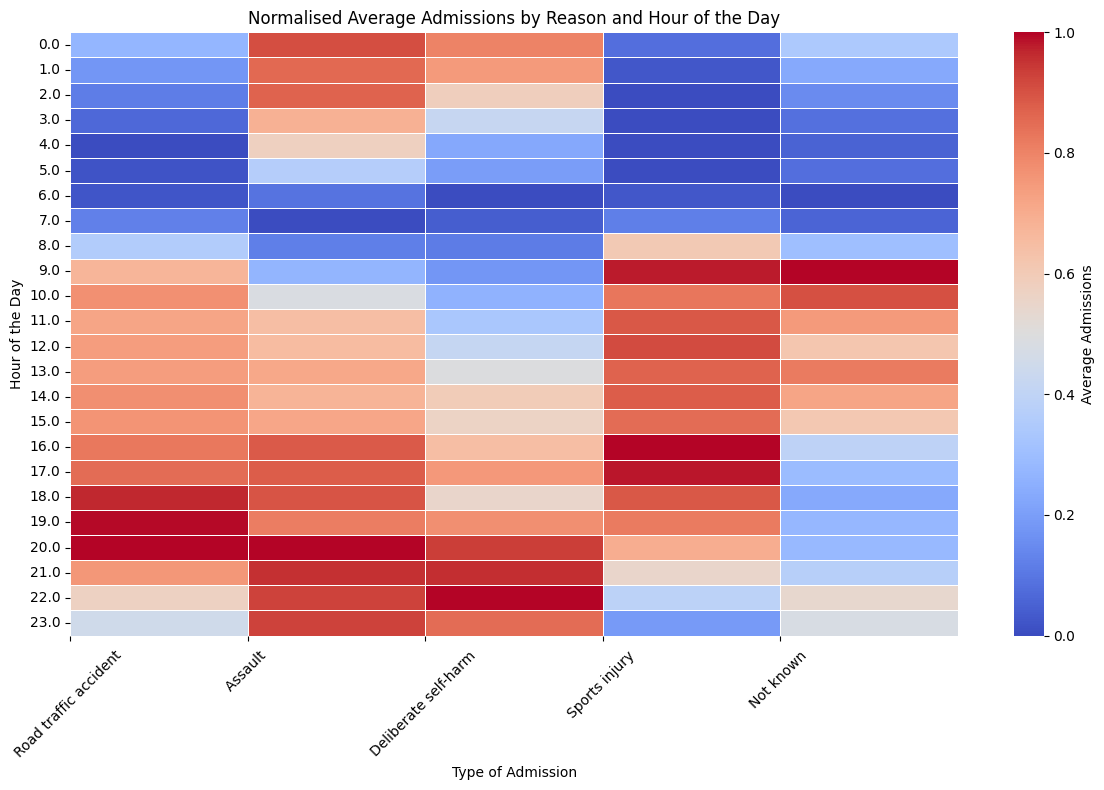

In [10]:
# Calculating the mean for each type of admission per hour.
hourly_data = df.groupby('Hour of arrival')[[
    'Road traffic accident ', 'Assault ', 'Deliberate self-harm ',
    'Sports injury ', 'Not known ']].mean()

# Normalize the data to bring each column to a comparable scale
normalized_data = hourly_data.apply(
    lambda x: (x - x.min()) /
     (x.max() - x.min()), axis=0)

# Heatmap to visualize the average admissions by reason and hour of the day.
print('\n INSIGHT 3: Normalised average Admissions per Reason and Hour of the Arrival.')

plt.figure(figsize=(12, 8))
sns.heatmap(normalized_data , annot=False, fmt='.1f', cmap='coolwarm',
            cbar_kws={'label': 'Average Admissions'}, linewidths=0.5)
plt.title('Normalised Average Admissions by Reason and Hour of the Day')
plt.ylabel('Hour of the Day')
plt.xlabel('Type of Admission')
plt.xticks(ticks=np.arange(len(hourly_data.columns)),
           labels=hourly_data.columns, rotation=45)
plt.tight_layout()
plt.show()
# Observation: On average, admissions vary by time of day and reason of attendance, with significant peaks and defined trends.